In [47]:
# =========================
# Standard Library
# =========================
import math

# =========================
# Data Manipulation
# =========================
import numpy as np
import pandas as pd

# =========================
# Visualization
# =========================
import matplotlib.pyplot as plt
import seaborn as sns

# =========================
# Statistical Tests
# =========================
from scipy.stats import f_oneway, ttest_ind

# =========================
# Scikit-Learn: Preprocessing & Pipeline
# =========================
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# =========================
# Scikit-Learn: Models
# =========================
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression

# =========================
# Scikit-Learn: Metrics
# =========================
from sklearn.metrics import (
    accuracy_score, confusion_matrix, f1_score, mean_absolute_error,
    mean_squared_error, precision_score, r2_score, recall_score,
    roc_auc_score, roc_curve
)

# =========================
# Optional / Advanced Models
# =========================
from xgboost import XGBClassifier, XGBRegressor
import shap

!pip install shap

In [48]:
def plot_feature_importances(df, title, palette="viridis", top_n=15):
    """
    Plots the top N feature importances from a dataframe with
    columns ['Feature', 'Importance'].
    Compatible with Seaborn 0.14+ (requires hue assignment).
    """

    plt.figure(figsize=(10, 6))
    sns.barplot(
        data=df.head(top_n),
        x="Importance",
        y="Feature",
        hue="Feature",
        palette=palette,
        legend=False
    )
    plt.title(title)
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.show()
    
def evaluate_classifier(y_true, y_pred, model_name):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)

    print(f"--- {model_name} ---")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1 Score:  {f1:.4f}")
    print("\nConfusion Matrix:")
    print(cm)
    print()

def evaluate_regression(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = math.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    print(f"--- {model_name} ---")
    print(f"MAE:  {mae:.4f}")
    print(f"MSE:  {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R²:   {r2:.4f}")
    print()
    
def run_eda_test(df, category_col, numeric_col):
    """
    Unified EDA function for:
    - Binary categorical vars (t-test + boxplot)
    - Multi-category vars (ANOVA + boxplot)

    Plots:
        Boxplot only (simple & professional)
    """

    groups = df[category_col].dropna().unique()
    n_groups = len(groups)

    print("=" * 80)
    print(f"EDA Analysis: {numeric_col} by {category_col}")
    print("=" * 80)

    # --------------------------------------------------
    #  Binary Category → T-Test + Boxplot
    # --------------------------------------------------
    if n_groups == 2:
        print("\nRunning Independent Samples T-Test...")

        g1, g2 = groups[0], groups[1]
        data1 = df[df[category_col] == g1][numeric_col]
        data2 = df[df[category_col] == g2][numeric_col]

        t_stat, p_value = ttest_ind(data1, data2, equal_var=False)

        print(f"\nGroup {g1} mean: {data1.mean():.3f}")
        print(f"Group {g2} mean: {data2.mean():.3f}")
        print(f"T-statistic: {t_stat:.4f}")
        print(f"P-value: {p_value:.6f}")

        if p_value < 0.05:
            print("Result: Significant difference between groups (p < 0.05).")
        else:
            print("Result: No significant difference between groups (p ≥ 0.05).")

        # ----- Boxplot -----
        plt.figure(figsize=(7,5))
        sns.boxplot(data=df, x=category_col, y=numeric_col)
        plt.title(f"{numeric_col} by {category_col}")
        plt.show()

    # --------------------------------------------------
    #  Multi-Category → ANOVA + Boxplot
    # --------------------------------------------------
    elif n_groups >= 3:
        print("\nRunning One-Way ANOVA...")

        samples = [df[df[category_col] == g][numeric_col] for g in groups]
        f_stat, p_value = f_oneway(*samples)

        print("\nGroup Means:")
        for g in groups:
            print(f"  {g}: {df[df[category_col] == g][numeric_col].mean():.3f}")

        print(f"\nF-statistic: {f_stat:.4f}")
        print(f"P-value: {p_value:.6f}")

        if p_value < 0.05:
            print("Result: Significant differences among groups (p < 0.05).")
        else:
            print("Result: No significant differences (p ≥ 0.05).")

        # ----- Boxplot -----
        plt.figure(figsize=(8,5))
        sns.boxplot(data=df, x=category_col, y=numeric_col)
        plt.title(f"{numeric_col} by {category_col}")
        plt.show()

    else:
        raise ValueError(f"Column '{category_col}' has fewer than 2 groups.")

    print("\n")

def plot_multiple_hists(df, columns, label_maps=None, column_descriptions=None,
                        ncols=3, figsize=(15, 8)):
    """
    Creates subplots of histograms / countplots side-by-side
    using label maps and descriptive titles.
    Automatically respects the order of label_maps for categorical columns.
    """
    nrows = math.ceil(len(columns) / ncols)
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    axes = axes.flatten()

    for i, col in enumerate(columns):
        ax = axes[i]
        col_data = df[col]
        desc = column_descriptions.get(col, col)

        # Apply mapping if exists
        if label_maps and col in label_maps:
            # convert to int safely before mapping
            col_data = pd.to_numeric(col_data, errors='coerce').fillna(-1).astype(int)
            data = col_data.map(label_maps[col])
            plot_type = "categorical"

            # ✅ Use order from mapping keys
            order = [label_maps[col][k] for k in label_maps[col].keys()]
        else:
            data = col_data
            plot_type = "numeric" if pd.api.types.is_numeric_dtype(col_data) else "categorical"
            order = sorted(data.dropna().unique()) if plot_type == "categorical" else None

        # Plot
        if plot_type == "numeric":
            sns.histplot(data.dropna(), bins=10, kde=True,
                         color='skyblue', edgecolor='black', ax=ax)
            ax.set_ylabel("Frequency")
        else:
            sns.countplot(x=data, color='lightgreen', order=order, ax=ax)
            ax.set_ylabel("Count")

        ax.set_xlabel(col)
        ax.set_title(f"{col} — {desc}", fontsize=10)

    # Hide any unused axes
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

# 1. Introduction and Problem Framing

### Introduction
Educational data mining and learning analytics are increasingly used to understand and support student success. Schools collect rich data on students’ demographics, study habits, attendance, and extracurricular involvement, but this information is often underutilized in decision-making. The Students Performance Dataset from Kaggle, shared by Rabie El Kharoua, contains several hundred student records with features describing family background, academic behaviors, and engagement (e.g., parental education, weekly study time, absences, tutoring, extracurricular activities, and more), along with each student’s GPA. This dataset provides a realistic context for exploring how machine learning can help identify patterns associated with academic performance.

In this project, we investigate how well different machine learning models can predict student GPA and identify which factors are most strongly associated with higher or lower performance. Our work is motivated by a practical educational question: if educators can identify at-risk students earlier and understand the drivers behind their outcomes, they may be able to design more targeted interventions, allocate resources more effectively, and improve overall student success.

### Problem Framing
We frame our task primarily as a supervised learning problem using the Kaggle Students Performance Dataset. Each row in the dataset represents a student, with input features such as gender, ethnicity, parental education, parental support, weekly study time, number of absences, and participation in activities like sports, music, volunteering, and tutoring. The main target variable is GPA, which we treat as a measure of overall academic performance.

From an applied perspective, there are two closely related questions:

* How accurately can we predict a student’s GPA from their background and behavior?

* Which factors are most predictive of higher or lower academic performance, and how might this inform intervention strategies?

Machine learning is well-suited to this problem because it can capture complex, potentially nonlinear relationships between multiple features and GPA. In addition to modeling GPA as a continuous outcome (regression), we can also define an “at-risk” threshold (e.g., GPA below a certain cutoff) and recast the task as a binary classification problem. This allows us to compare different algorithm families (e.g., linear models vs. tree-based models) and evaluate both predictive performance and interpretability. Our project also satisfies the course requirement to explore multiple AI/ML approaches by implementing and comparing several algorithms such as linear or logistic regression, random forests, and gradient-boosted models (e.g., XGBoost), and by examining how model performance changes with hyperparameter tuning.

### Project Goals and Scope
Using the Students Performance Dataset, our project aims to:

* Perform exploratory data analysis (EDA) to understand distributions, relationships, and potential data quality issues.

* Build a clean preprocessing pipeline (handling missing values, encoding categorical variables, and scaling where appropriate).

* Train and compare multiple machine learning models (e.g., regression and classification approaches, including linear and tree-based methods) to predict student performance.

* Conduct experimental comparisons, such as baseline vs. tuned models and comparisons across different algorithm families, using metrics like MAE/RMSE for regression and accuracy, precision, recall, F1-score, and ROC-AUC for classification.

* Use feature importance and related explainability tools to identify which factors most strongly influence GPA and at-risk status.

* Interpret our findings in terms of actionable insights for educators, while acknowledging limitations such as dataset scope, potential biases, and the difference between correlation and causation.

By the end of the project, we aim to deliver a reproducible, well-documented workflow that demonstrates the full applied AI lifecycle—from problem framing and EDA through modeling, comparison, and interpretation—while showing how data-driven methods can support more informed decisions in education.

# 2. Data Loading and Overview

In [49]:
students = pd.read_csv("https://img1.wsimg.com/blobby/go/95a603d1-9621-42dd-ac5a-bc61ff2699b4/downloads/dd29d21b-f1eb-4d17-8426-43233aafe601/Student_performance_data%20_.csv?ver=1762568366189")

In [50]:
students.head()

,StudentID,Age,Gender,Ethnicity,ParentalEducation,StudyTimeWeekly,Absences,Tutoring,ParentalSupport,Extracurricular,Sports,Music,Volunteering,GPA,GradeClass
0,1001,17,1,0,2,19.833723,7,1,2,0,0,1,0,2.929196,2.0
1,1002,18,0,0,1,15.408756,0,0,1,0,0,0,0,3.042915,1.0
2,1003,15,0,2,3,4.210570,26,0,2,0,0,0,0,0.112602,4.0
3,1004,17,1,0,3,10.028829,14,0,3,1,0,0,0,2.054218,3.0
4,1005,17,1,0,2,4.672495,17,1,3,0,0,0,0,1.288061,4.0


In [51]:
students.drop(columns=['StudentID'], inplace=True)

In [52]:
students.describe()

,Age,Gender,Ethnicity,ParentalEducation,StudyTimeWeekly,Absences,Tutoring,ParentalSupport,Extracurricular,Sports,Music,Volunteering,GPA,GradeClass
count,2392.000000,2392.000000,2392.000000,2392.000000,2392.000000,2392.000000,2392.000000,2392.000000,2392.000000,2392.000000,2392.000000,2392.000000,2392.000000,2392.000000
mean,16.468645,0.510870,0.877508,1.746237,9.771992,14.541388,0.301421,2.122074,0.383361,0.303512,0.196906,0.157191,1.906186,2.983696
std,1.123798,0.499986,1.028476,1.000411,5.652774,8.467417,0.458971,1.122813,0.486307,0.459870,0.397744,0.364057,0.915156,1.233908
min,15.000000,0.000000,0.000000,0.000000,0.001057,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,15.000000,0.000000,0.000000,1.000000,5.043079,7.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.174803,2.000000
50%,16.000000,1.000000,0.000000,2.000000,9.705363,15.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,1.893393,4.000000
75%,17.000000,1.000000,2.000000,2.000000,14.408410,22.000000,1.000000,3.000000,1.000000,1.000000,0.000000,0.000000,2.622216,4.000000
max,18.000000,1.000000,3.000000,4.000000,19.978094,29.000000,1.000000,4.000000,1.000000,1.000000,1.000000,1.000000,4.000000,4.000000


In [53]:
students.dtypes

Age                    int64
Gender                 int64
Ethnicity              int64
ParentalEducation      int64
StudyTimeWeekly      float64
Absences               int64
Tutoring               int64
ParentalSupport        int64
Extracurricular        int64
Sports                 int64
Music                  int64
Volunteering           int64
GPA                  float64
GradeClass           float64
dtype: object

In [54]:
students.isnull().sum()

Age                  0
Gender               0
Ethnicity            0
ParentalEducation    0
StudyTimeWeekly      0
Absences             0
Tutoring             0
ParentalSupport      0
Extracurricular      0
Sports               0
Music                0
Volunteering         0
GPA                  0
GradeClass           0
dtype: int64

| Feature | Description |
|--------|-------------|
| **StudentID** | Unique identifier for each student (1001–3392). |
| **Age** | Age of the student (15–18 years). |
| **Gender** | 0 = Male, 1 = Female |
| **Ethnicity** | 0 = Caucasian, 1 = African American, 2 = Asian, 3 = Other |
| **ParentalEducation** | 0 = None, 1 = High School, 2 = Some College, 3 = Bachelor's, 4 = Higher |
| **StudyTimeWeekly** | Hours spent studying per week (0–20). |
| **Absences** | Number of school absences per year (0–30). |
| **Tutoring** | 0 = No, 1 = Yes |
| **ParentalSupport** | 0 = None, 1 = Low, 2 = Moderate, 3 = High, 4 = Very High |
| **Extracurricular** | 0 = No, 1 = Yes |
| **Sports** | 0 = No, 1 = Yes |
| **Music** | 0 = No, 1 = Yes |
| **Volunteering** | 0 = No, 1 = Yes |
| **GPA** | Grade Point Average (2.0–4.0). |
| **GradeClass** | 0=A, 1=B, 2=C, 3=D, 4=F |

### The dataset contains no missing values, but several categorical features are represented using numeric codes (e.g., 0–3 for Ethnicity, 0–4 for ParentalSupport). Although these codes are numeric, they do not represent continuous or ordinal quantities. To avoid misleading correlations and ensure proper preprocessing later, we explicitly convert these columns to the category dtype.

### This conversion:
- preserves the original values
- clarifies that these features are nominal categories
- prevents them from being incorrectly treated as numeric during EDA
- ensures that later encoding methods (e.g., pd.get_dummies) handle them correctly

In [55]:
categorical_cols = [
    "Gender",
    "Ethnicity",
    "ParentalEducation",
    "ParentalSupport",
    "Tutoring",
    "Extracurricular",
    "Sports",
    "Music",
    "Volunteering"
]
students[categorical_cols] = students[categorical_cols].astype("category")

In [56]:
students_catogory = students.select_dtypes(include=['category'])
students_numeric = students.select_dtypes(include="number")
students.dtypes

Age                     int64
Gender               category
Ethnicity            category
ParentalEducation    category
StudyTimeWeekly       float64
Absences                int64
Tutoring             category
ParentalSupport      category
Extracurricular      category
Sports               category
Music                category
Volunteering         category
GPA                   float64
GradeClass            float64
dtype: object

# 3. Data Visualization

In [57]:
# Mapping dictionaries for each categorical column
label_maps = {
    "Gender": {
        0: "Male",
        1: "Female"
    },
    "Ethnicity": {
        0: "Caucasian",
        1: "African American",
        2: "Asian",
        3: "Other"
    },
    "ParentalEducation": {
        0: "None",
        1: "High School",
        2: "Some College",
        3: "Bachelor's",
        4: "Higher"
    },
    "ParentalSupport": {
        0: "None",
        1: "Low",
        2: "Moderate",
        3: "High",
        4: "Very High"
    },
    "Tutoring": {0: "No", 1: "Yes"},
    "Extracurricular": {0: "No", 1: "Yes"},
    "Sports": {0: "No", 1: "Yes"},
    "Music": {0: "No", 1: "Yes"},
    "Volunteering": {0: "No", 1: "Yes"},
    "GradeClass": {
        0: "A",
        1: "B",
        2: "C",
        3: "D",
        4: "F"
    }
}


# Column descriptions (based on your dataset dictionary)
column_descriptions = {
    "StudentID": "Unique identifier for each student.",
    "Age": "Age of the student.",
    "Gender": "Student gender.",
    "Ethnicity": "Student ethnicity.",
    "ParentalEducation": "Highest level of parental education.",
    "StudyTimeWeekly": "Average weekly study time in hours.",
    "Absences": "Total number of school absences.",
    "Tutoring": "Indicates whether the student receives tutoring.",
    "ParentalSupport": "Level of parental support for the student.",
    "Extracurricular": "Participation in extracurricular activities.",
    "Sports": "Participation in sports programs.",
    "Music": "Participation in music activities.",
    "Volunteering": "Participation in volunteering or community service.",
    "GPA": "Student’s Grade Point Average.",
    "GradeClass": "Overall academic performance represented by letter grade."
}



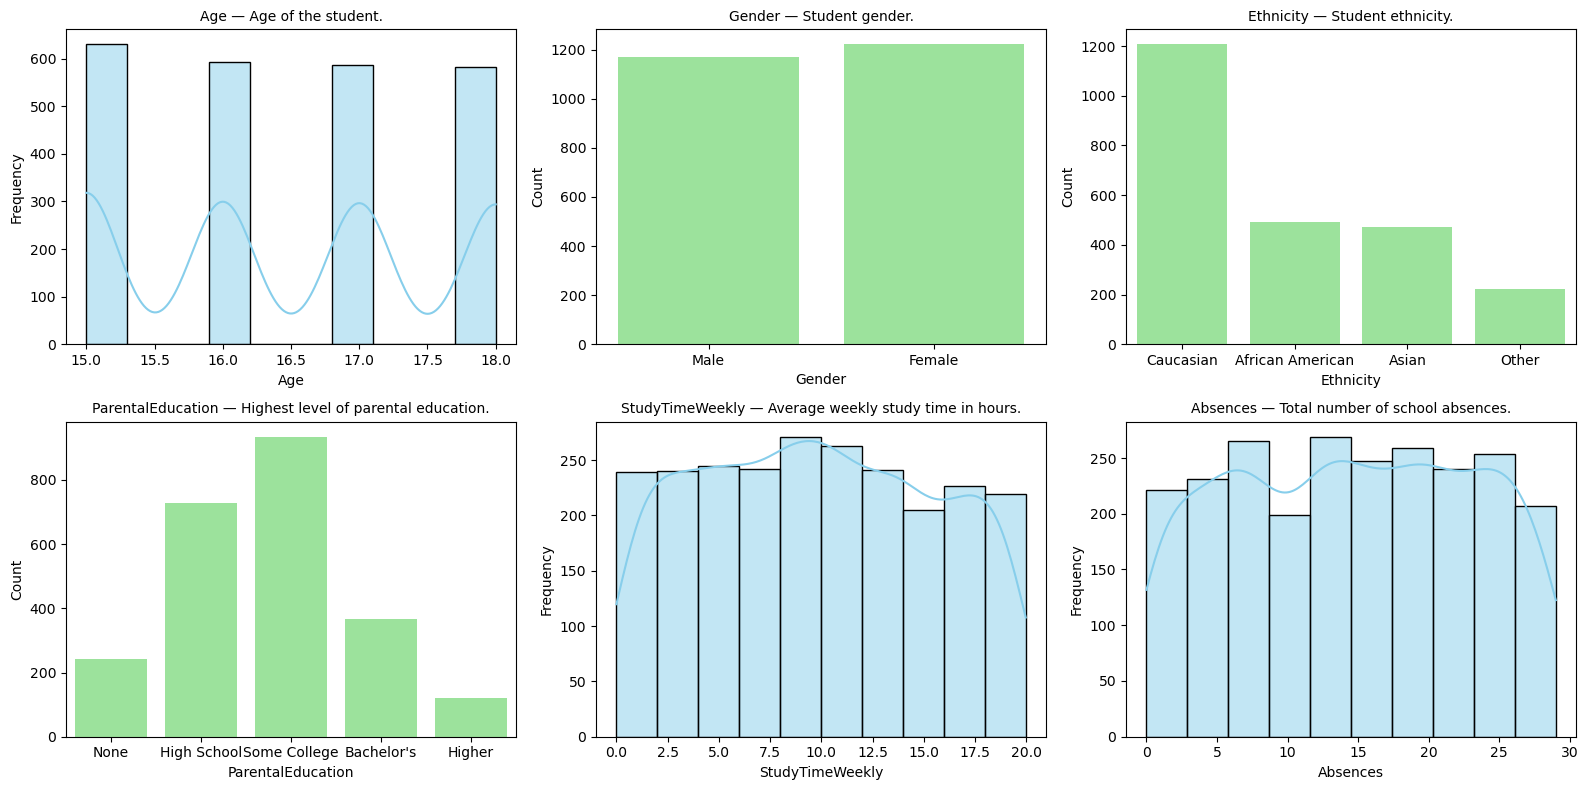

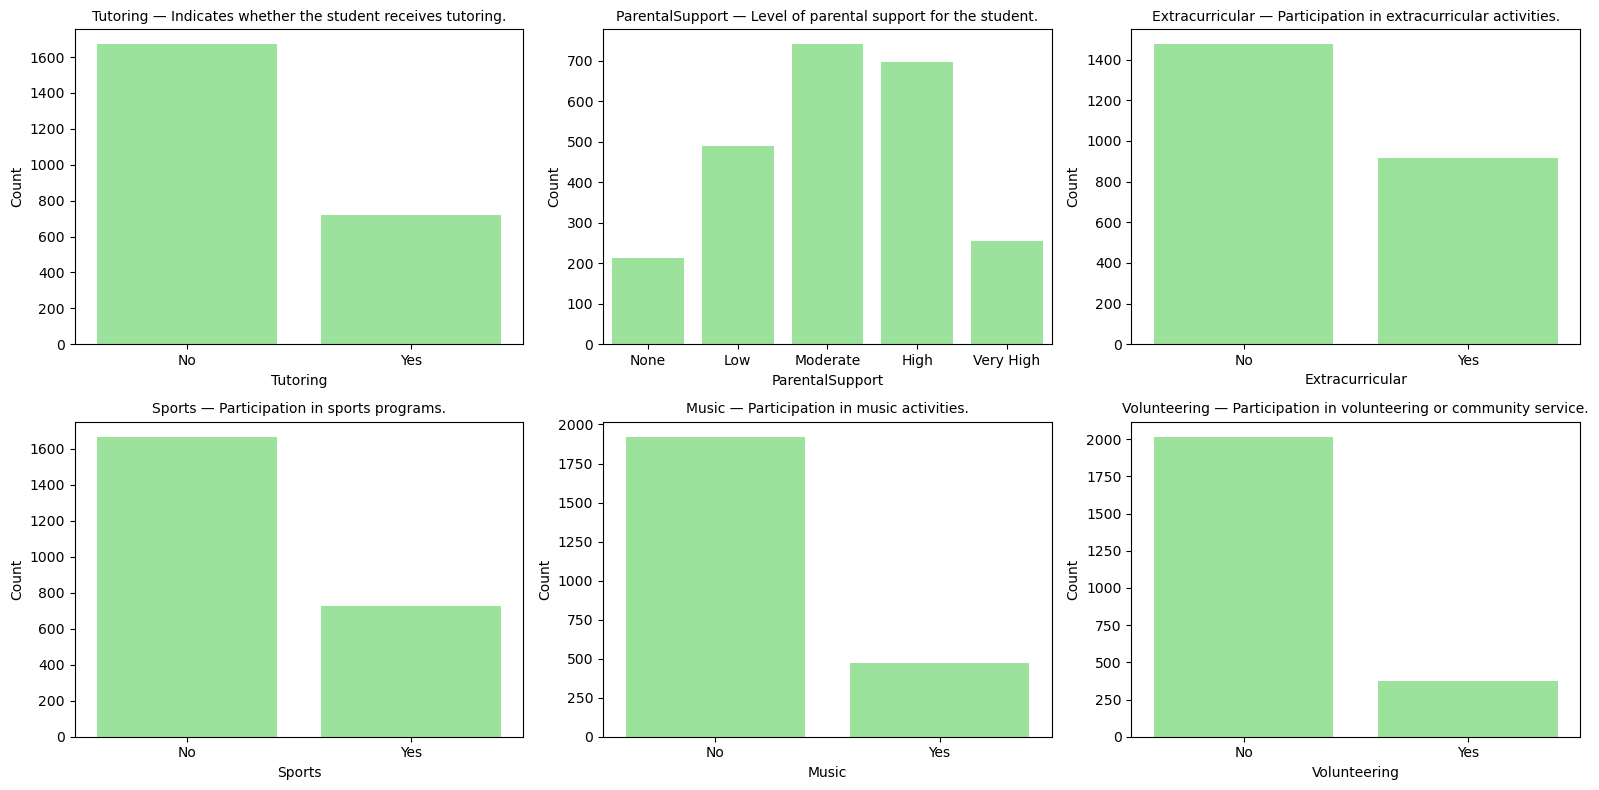

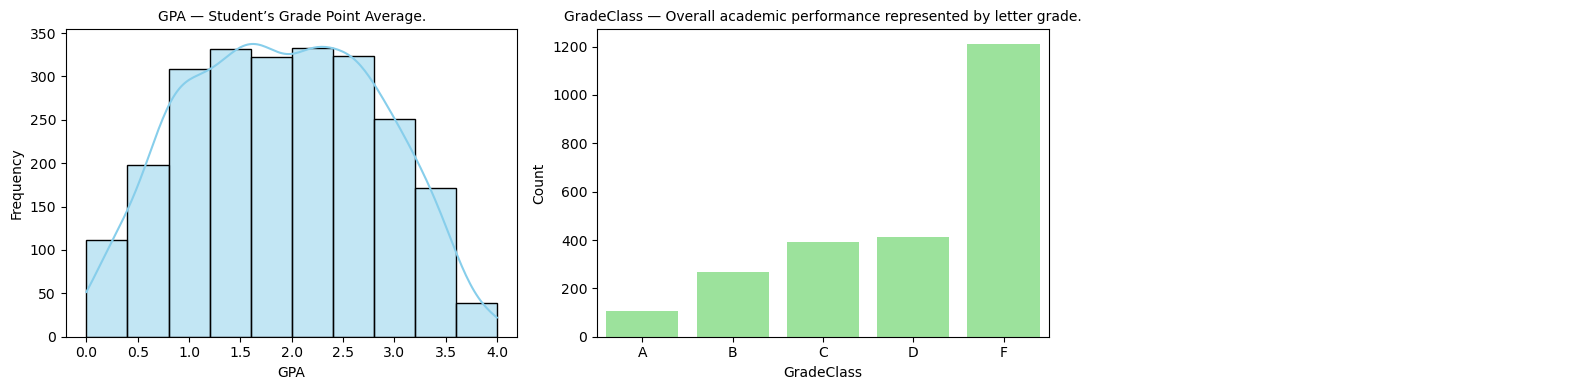

In [58]:
plot_multiple_hists(
    students,
    columns=students.columns[:6],
    label_maps=label_maps,
    column_descriptions=column_descriptions,
    ncols=3,
    figsize=(16, 8)
)
plot_multiple_hists(
    students,
    columns=students.columns[6:12],
    label_maps=label_maps,
    column_descriptions=column_descriptions,
    ncols=3,
    figsize=(16, 8)
)

plot_multiple_hists(
    students,
    columns=students.columns[12:],
    label_maps=label_maps,
    column_descriptions=column_descriptions,
    ncols=3,
    figsize=(16, 4)
)

### Descriptive Statistics for Each Feature

- **Age:** Uniform distribution between ages 15–18 with no dominant age group.  
- **Gender:** Roughly balanced split between male and female students.  
- **Ethnicity:** Imbalanced, with Caucasian students forming the majority; “Other” least represented.  
- **ParentalEducation:** Skewed toward “Some College” and “High School”; very few in “Higher” or “None.”  
- **StudyTimeWeekly:** Evenly spread across 0–20 hours with no dominant cluster.  
- **Absences:** Ranges from 0–30 days with a fairly uniform distribution.  
- **Tutoring:** Most students do not receive tutoring; small minority does.  
- **ParentalSupport:** Distributed across all five levels, with “Moderate” and “High” most common.  
- **Extracurricular:** Majority of students do not participate in extracurricular activities.  
- **Sports:** Strong imbalance, with many more non-participants than participants.  
- **Music:** Highly imbalanced, with most students not involved in music activities.  
- **Volunteering:** Majority of students do not volunteer.  
- **GPA:** Approximately symmetric distribution from 2.0–4.0, peaking mid–high GPA.  
- **GradeClass:** Strongly imbalanced, with “F” the most common grade class.

# 4. Exploratory Data Analysis

<bound method NDFrame.describe of                       Age  StudyTimeWeekly  Absences       GPA  GradeClass
Age              1.000000        -0.006800 -0.011511  0.000275   -0.006250
StudyTimeWeekly -0.006800         1.000000  0.009326  0.179275   -0.134131
Absences        -0.011511         0.009326  1.000000 -0.919314    0.728633
GPA              0.000275         0.179275 -0.919314  1.000000   -0.782835
GradeClass      -0.006250        -0.134131  0.728633 -0.782835    1.000000>


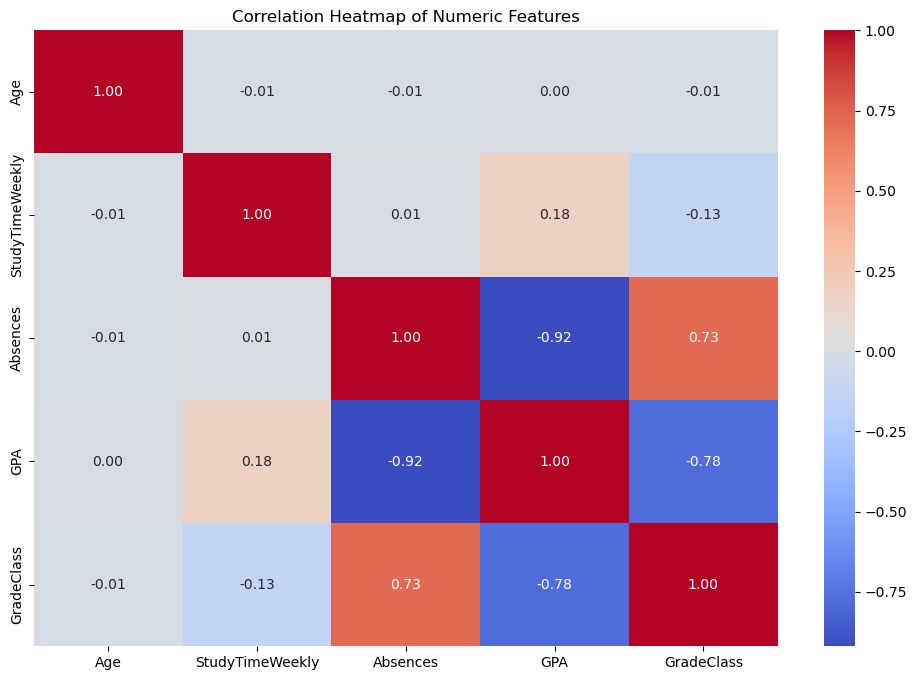

In [59]:
# Compute correlation matrix
corr = students_numeric.corr()

print(corr.describe)
# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap of Numeric Features")
plt.show()

### Interpretation of Heatmap Relationships
- It is surprising to see that StudyTimeWeekly shows only a negligible correlation with GPA, suggesting that simply spending more hours studying does not strongly predict academic performance in this dataset.
- In contrast, and consistent with expectations, Absences show a very strong negative correlation with GPA, indicating that missing classes is one of the most influential factors associated with lower academic performance.
- Additionally, GPA and GradeClass are highly correlated because GradeClass is directly derived from GPA. To prevent data leakage and redundancy, GradeClass will be removed during preprocessing.

In [60]:
students_catogory.describe()

,Gender,Ethnicity,ParentalEducation,Tutoring,ParentalSupport,Extracurricular,Sports,Music,Volunteering
count,2392,2392,2392,2392,2392,2392,2392,2392,2392
unique,2,4,5,2,5,2,2,2,2
top,1,0,2,0,2,0,0,0,0
freq,1222,1207,934,1671,740,1475,1666,1921,2016


## 🧪 Statistical Tests Used: T-Test and ANOVA, conventional alpha of 0.05
### Independent Samples T-Test (Binary Categorical Variables)
- We use t-tests when comparing mean GPA between two groups (e.g., Gender, Tutoring, Sports).
- A t-test evaluates whether the difference in mean GPA is large enough relative to natural variability within each group to conclude that the groups truly differ rather than the difference arising by chance.
- The t-statistic is not simply the difference in group means; it also adjusts for within-group variability, sample size, and the standard error of the difference.
- This allows us to determine whether the GPA difference between two categories is statistically meaningful.

### One-Way ANOVA (Categorical Variables with 3 or More Groups)
- We use one-way ANOVA when comparing mean GPA across three or more categories (e.g., Ethnicity, ParentalEducation, ParentalSupport).
- ANOVA evaluates whether at least one group mean differs from the others by comparing variation between groups to variation within groups.
- If the between-group variation is substantially larger than the within-group variation, the F-statistic becomes large, indicating that not all group means are equal.
- ANOVA is necessary because it avoids inflated Type I error from running multiple t-tests, properly handles 3+ group comparisons in a single unified test, and determines whether meaningful group differences exist before examining specific pairs.
    - A Type I error occurs when we incorrectly conclude that a significant difference exists between groups when it actually does not — essentially a false positive.

EDA Analysis: GPA by Gender

Running Independent Samples T-Test...

Group 1 mean: 1.894
Group 0 mean: 1.919
T-statistic: -0.6532
P-value: 0.513668
Result: No significant difference between groups (p ≥ 0.05).


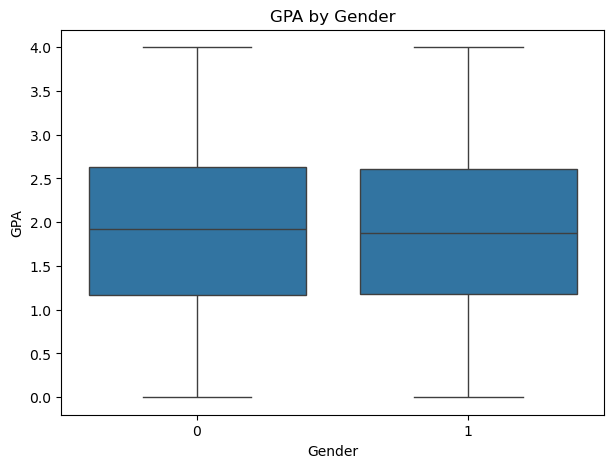



EDA Analysis: GPA by Tutoring

Running Independent Samples T-Test...

Group 1 mean: 2.108
Group 0 mean: 1.819
T-statistic: 7.1725
P-value: 0.000000
Result: Significant difference between groups (p < 0.05).


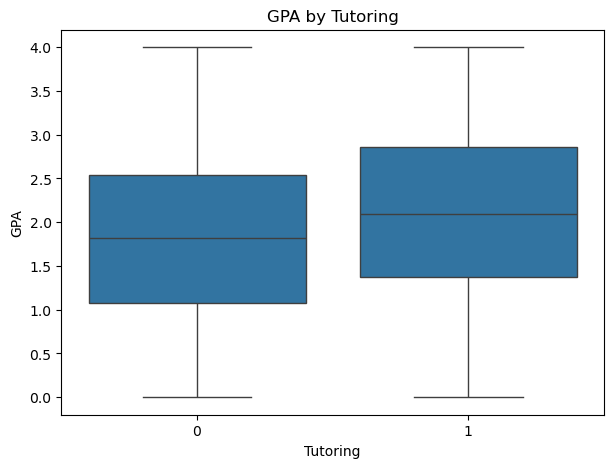



EDA Analysis: GPA by Extracurricular

Running Independent Samples T-Test...

Group 0 mean: 1.838
Group 1 mean: 2.015
T-statistic: -4.6086
P-value: 0.000004
Result: Significant difference between groups (p < 0.05).


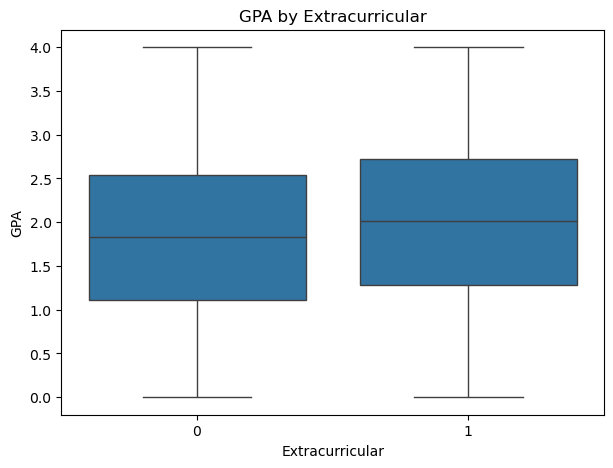



EDA Analysis: GPA by Sports

Running Independent Samples T-Test...

Group 0 mean: 1.871
Group 1 mean: 1.986
T-statistic: -2.8514
P-value: 0.004416
Result: Significant difference between groups (p < 0.05).


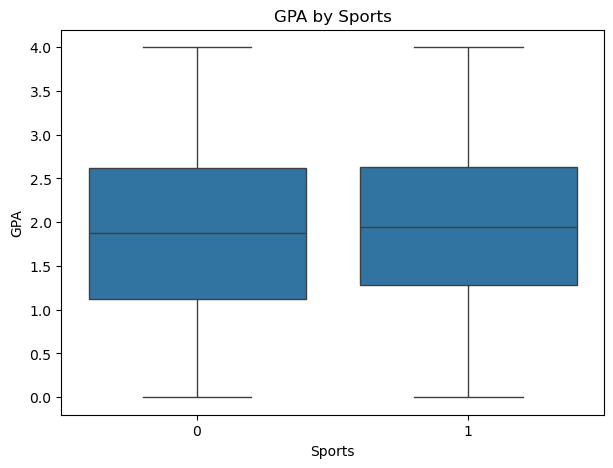



EDA Analysis: GPA by Music

Running Independent Samples T-Test...

Group 1 mean: 2.042
Group 0 mean: 1.873
T-statistic: 3.5971
P-value: 0.000344
Result: Significant difference between groups (p < 0.05).


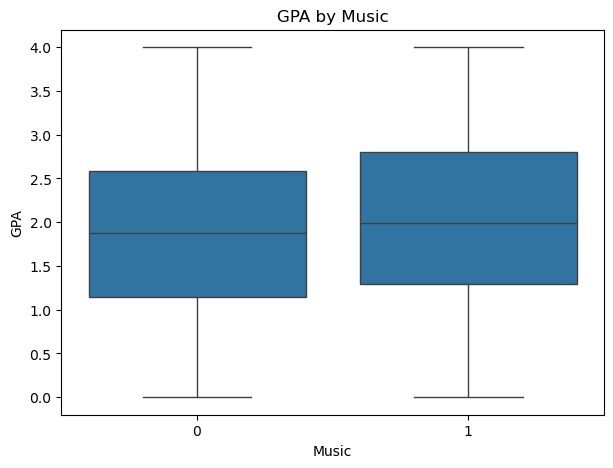



EDA Analysis: GPA by Volunteering

Running Independent Samples T-Test...

Group 0 mean: 1.905
Group 1 mean: 1.913
T-statistic: -0.1611
P-value: 0.872068
Result: No significant difference between groups (p ≥ 0.05).


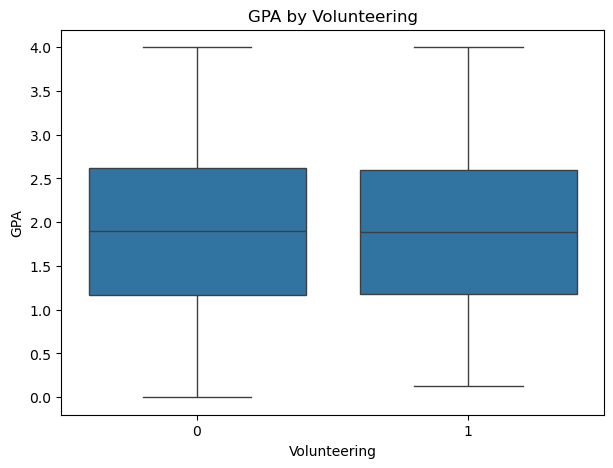



EDA Analysis: GPA by Ethnicity

Running One-Way ANOVA...

Group Means:
  0: 1.876
  2: 1.922
  1: 1.946
  3: 1.948

F-statistic: 0.9581
P-value: 0.411585
Result: No significant differences (p ≥ 0.05).


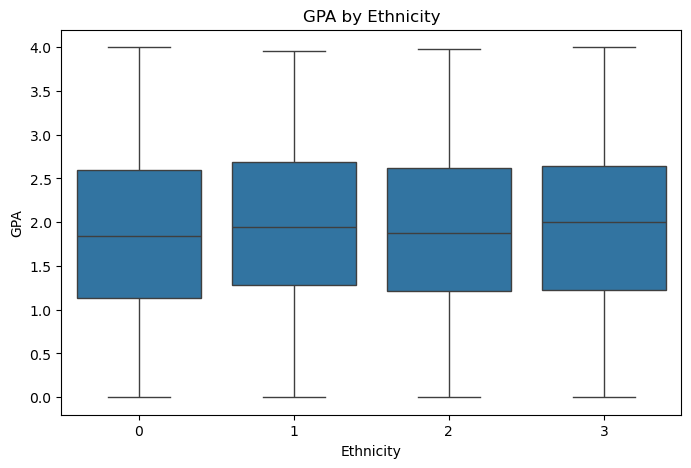



EDA Analysis: GPA by ParentalEducation

Running One-Way ANOVA...

Group Means:
  2: 1.930
  1: 1.944
  3: 1.809
  4: 1.816
  0: 1.893

F-statistic: 1.8081
P-value: 0.124484
Result: No significant differences (p ≥ 0.05).


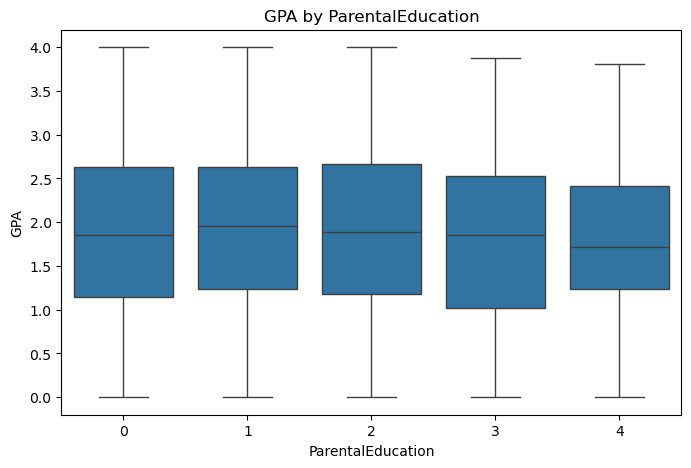



EDA Analysis: GPA by ParentalSupport

Running One-Way ANOVA...

Group Means:
  2: 1.884
  1: 1.756
  3: 2.042
  4: 2.192
  0: 1.540

F-statistic: 22.7235
P-value: 0.000000
Result: Significant differences among groups (p < 0.05).


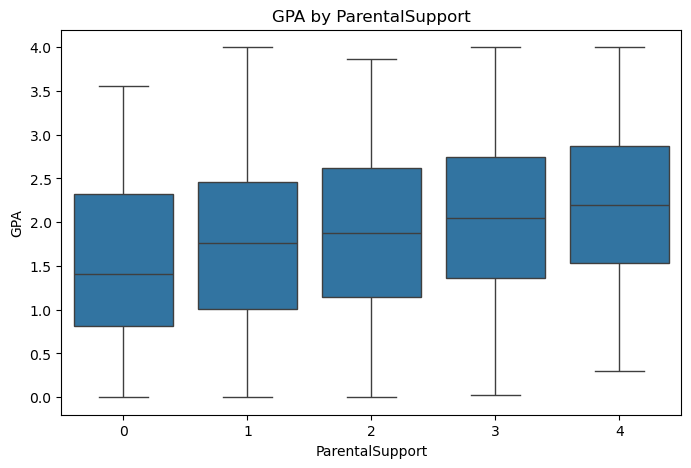

In [61]:
# Binary (t-test)
run_eda_test(students, "Gender", "GPA")
run_eda_test(students, "Tutoring", "GPA")
run_eda_test(students, "Extracurricular", "GPA")
run_eda_test(students, "Sports", "GPA")
run_eda_test(students, "Music", "GPA")
run_eda_test(students, "Volunteering", "GPA")

# Multi-category (ANOVA)
run_eda_test(students, "Ethnicity", "GPA")
run_eda_test(students, "ParentalEducation", "GPA")
run_eda_test(students, "ParentalSupport", "GPA")

### Summary of EDA Findings

#### Based on the exploratory data analysis performed, several categorical and numerical features show statistically significant relationships with student GPA.

### Significant Categorical Predictors of GPA
- **ParentalSupport** — ANOVA results indicate strong differences in mean GPA across support levels, with higher parental support consistently associated with higher GPA.
- **Music Participation** — Students involved in music activities show significantly different GPA distributions compared to those who are not.
- **Sports Participation** — Students who participate in sports demonstrate significantly different GPA outcomes relative to non-athletes.
- **Extracurricular Activities** — Involvement in extracurricular activities is associated with meaningful differences in GPA.
- **Tutoring** — Receiving tutoring is significantly related to GPA, with tutored students showing different academic performance on average.

### Significant Numerical Predictor of GPA
- **Absences** — There is a very strong negative correlation between absences and GPA (r ≈ -0.92), indicating that higher absences are strongly associated with lower academic performance.

### Exploratory Data Analysis Interpretation
The EDA results suggest that both **student engagement activities** (music, sports, extracurriculars, tutoring) and **family-related support factors** (parental support) play important roles in academic achievement. However, **absences** emerge as the single strongest predictor, demonstrating that attendance has a substantial impact on student GPA. These findings highlight the importance of both behavioral and environmental factors in influencing student success.

# 5. Modeling: Predicting Student Performance

#### In the previous sections, we explored the dataset through descriptive statistics and visual analysis to understand initial patterns and relationships. However, these insights only provide a qualitative understanding of the factors that may influence student performance. In this section, we move from exploratory data analysis (EDA) to building predictive models.

#### We use the `students` DataFrame prepared above and the existing `categorical_cols` to:

- Predict GPA as a continuous outcome (regression)
- Predict whether a student is "at risk" based on GPA (classification)
- Compare multiple models within each task

## 5.1 Model Theory Overview

This section provides a clear, theoretical foundation for all machine learning models we use in our project.  
It explains the mathematical intuition, core algorithms, and why each method is appropriate for predicting GPA, classifying at-risk students, and discovering natural groups through clustering.

---

### Linear Regression (GPA Prediction)

Linear Regression models the relationship between a set of predictors \(X\) and a continuous outcome \(y\).  
It assumes that GPA can be expressed as a weighted sum of features plus noise:

$$
y = X\beta + \epsilon
$$

The goal is to find coefficients \(\beta\) that minimize the Mean Squared Error (MSE):

$$
\text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2
$$

Linear Regression is interpretable and provides a strong baseline.  
It helps quantify how each variable contributes to GPA under a linear assumption.

---

### Logistic Regression (Binary At-Risk Classification)

Logistic Regression models the probability that a student is “at risk” (1) vs. “not at risk” (0).  
Instead of modeling the outcome directly, it models the log-odds:

$$
\log\left(\frac{p}{1 - p}\right) = X\beta
$$

Predicted probabilities come from the sigmoid function:

$$
p = \frac{1}{1 + e^{-X\beta}}
$$

Training minimizes Binary Cross-Entropy loss:

$$
\mathcal{L} = -\frac{1}{n}\sum_{i=1}^n \left[y_i \log(\hat{p}_i) + (1 - y_i)\log(1 - \hat{p}_i)\right]
$$

Logistic Regression is highly interpretable and establishes a strong classification baseline.

---

### Decision Trees

Decision Trees recursively split the feature space into regions, learning a set of human-readable rules.  
At each split, the algorithm chooses the feature and threshold that most reduce impurity.

**Gini Impurity:**
$$
G = \sum_{k=1}^{K} p_k (1 - p_k)
$$

**Entropy:**
$$
H = -\sum_{k=1}^{K} p_k \log(p_k)
$$

Decision trees naturally model nonlinear relationships and interactions between features.

---

### Random Forests (Ensemble of Decision Trees)

Random Forests are ensembles of many decision trees trained on:
- Bootstrap samples of the data  
- Random subsets of features at each split  

This decorrelation creates a more stable, lower-variance model.

Predictions are aggregated via:
- Mean (regression)  
- Majority vote (classification)

Random Forests handle mixed data types, nonlinearities, and high-dimensional spaces extremely well.

---

### XGBoost (Extreme Gradient Boosting)

XGBoost builds trees sequentially, where each tree corrects the errors of previous trees.  
This is called gradient boosting, and XGBoost extends it with regularization and second-order optimization.

Additive model:
$$
\hat{y}^{(t)} = \hat{y}^{(t-1)} + f_t(x)
$$

Objective function:
$$
\mathcal{L} = \sum_{i=1}^{n} l(y_i, \hat{y}_i) + \sum_{t} \Omega(f_t)
$$

Regularization term:
$$
\Omega(f_t) = \gamma T + \frac{1}{2}\lambda \sum_j w_j^2
$$

XGBoost is powerful due to:
- Use of first and second derivatives  
- Built-in L1/L2 regularization  
- Ability to model complex nonlinear relationships  
- Exceptional performance on tabular data  

This model often provides the strongest results in both regression and classification tasks.

---

### K-Means Clustering

K-Means is an unsupervised algorithm that separates observations into \(k\) clusters by minimizing within-cluster variance:

$$
\sum_{i=1}^{k} \sum_{x \in C_i} \|x - \mu_i\|^2
$$

Where \(\mu_i\) is the centroid of cluster \(i\).  
The algorithm iterates between:

1. Assigning each point to the nearest centroid  
2. Updating centroids as the mean of the assigned points  

This method identifies natural student subgroups (e.g., high performers, inconsistent performers), adding insight beyond supervised modeling.

---

### Principal Component Analysis (PCA)

PCA reduces dimensionality by finding directions (principal components) that capture the most variance in the data.

Optimization problem:
$$
\max_{\mathbf{w}} \ \mathbf{w}^T \Sigma \mathbf{w}
$$

Eigenvalue equation:
$$
\Sigma \mathbf{w} = \lambda \mathbf{w}
$$

PCA allows:
- Visualization of clusters  
- Noise reduction  
- Understanding feature relationships  

It is especially helpful for plotting K-Means results in 2D.

---

### Summary of Model Purpose in This Project

- **Linear Regression:** Baseline GPA prediction  
- **Logistic Regression:** Baseline binary at-risk classification  
- **Decision Trees:** Rule-based, interpretable models  
- **Random Forests:** Strong nonlinear ensemble models  
- **XGBoost:** High-performance boosting model with regularization  
- **K-Means:** Unsupervised discovery of student subgroups  
- **PCA:** Dimensionality reduction and visualization  

Together, these models provide a rich combination of predictive power, interpretability, and exploratory insight.

## 5.2 Data Preprocessing and Train/Test Split

#### We define an “at-risk” student as one whose GPA falls below 2.5. This threshold roughly corresponds to a C average and is commonly used in academic performance research to identify students who may require additional support. Students below this cutoff are labeled with `at_risk = 1`.

#### In this section, we prepare the dataset for all subsequent modeling steps by defining the regression and classification targets, selecting numerical and categorical features, and constructing a unified preprocessing pipeline. Numerical variables are standardized using `StandardScaler`, while categorical variables are encoded with `OneHotEncoder` to ensure that every model receives clean, machine-readable inputs. After establishing the preprocessing pipeline, we generate train–test splits for both the regression and classification tasks. These steps create a consistent, reproducible foundation for the supervised and unsupervised models developed in later sections of Chapter 5.

In [62]:
# Regression target
target_reg = "GPA"

# Classification target: 1 = at risk (low GPA), 0 = not at risk
risk_threshold = 2.5  # adjust if needed
students["at_risk"] = (students["GPA"] < risk_threshold).astype(int)
target_clf = "at_risk"

In [63]:
# Define numeric and categorical features using existing variables from our EDA

# Numeric features = all numeric columns except the targets
numeric_features = students.select_dtypes(include=["int64", "float64"]).columns.tolist()

# Remove targets from numeric feature list
for col in [target_reg, target_clf]:
    if col in numeric_features:
        numeric_features.remove(col)

# Explicitly remove GradeClass if it shows up as numeric (safety against leakage)
if "GradeClass" in numeric_features:
    numeric_features.remove("GradeClass")

# If you have any ID-like columns, drop them here manually, e.g.:
# if "StudentID" in numeric_features:
#     numeric_features.remove("StudentID")

numeric_features, categorical_cols

(['Age', 'StudyTimeWeekly', 'Absences'],
 ['Gender',
  'Ethnicity',
  'ParentalEducation',
  'ParentalSupport',
  'Tutoring',
  'Extracurricular',
  'Sports',
  'Music',
  'Volunteering'])

In [64]:
# Preprocessing pipeline and train/test split

# ColumnTransformer to scale numerics and one-hot encode categoricals
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols)
    ]
)

# Feature matrix (same for both tasks)
X = students[numeric_features + categorical_cols]

# Targets
y_reg = students[target_reg]
y_clf = students[target_clf]

# Train/test splits
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X, y_reg, test_size=0.2, random_state=42
)

X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X, y_clf, test_size=0.2, random_state=42
)

## 5.3 Regression Model Training and Evaluation

#### In this section, we train several regression models using the preprocessing pipeline defined in Section 5.2. Each model is fitted on the training data and evaluated on the test set using a standardized regression evaluation function. The goal here is to generate performance metrics that will be interpreted and compared in Section 6.

In [65]:
# Linear Regression
linreg_model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", LinearRegression())
])

linreg_model.fit(X_train_reg, y_train_reg)
y_pred_linreg = linreg_model.predict(X_test_reg)

evaluate_regression(y_test_reg, y_pred_linreg, "Linear Regression")

--- Linear Regression ---
MAE:  0.1551
MSE:  0.0385
RMSE: 0.1963
R²:   0.9534



In [66]:
# Random Forest Regressor
rf_reg_model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", RandomForestRegressor(
        n_estimators=200,
        random_state=42
    ))
])

rf_reg_model.fit(X_train_reg, y_train_reg)
y_pred_rf_reg = rf_reg_model.predict(X_test_reg)

evaluate_regression(y_test_reg, y_pred_rf_reg, "Random Forest Regressor")

--- Random Forest Regressor ---
MAE:  0.1960
MSE:  0.0639
RMSE: 0.2527
R²:   0.9228



In [67]:
# XGBoost Regressor (because it's popular and I'm curious to compare)
xgb_reg_model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", XGBRegressor(
        n_estimators=300,
        learning_rate=0.1,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    ))
])

xgb_reg_model.fit(X_train_reg, y_train_reg)
y_pred_xgb_reg = xgb_reg_model.predict(X_test_reg)

evaluate_regression(y_test_reg, y_pred_xgb_reg, "XGBoost Regressor")

--- XGBoost Regressor ---
MAE:  0.1836
MSE:  0.0542
RMSE: 0.2328
R²:   0.9345



## 5.4 Classification Model Training and Evaluation

#### In this section, we train multiple classification models to predict whether a student is “at risk” according to the 2.5 GPA threshold defined in Section 5.2. Each classifier is wrapped in the same preprocessing pipeline used earlier, ensuring consistent scaling of numerical features and one-hot encoding of categorical variables. We fit each model on the training data and generate performance metrics on the test set using a standardized evaluation function. These metrics serve as the raw outputs for comparison in Chapter 6, with full interpretation provided in Chapter 7.

In [68]:
# logistic regression
log_clf_model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", LogisticRegression(max_iter=500))
])

log_clf_model.fit(X_train_clf, y_train_clf)
y_pred_log = log_clf_model.predict(X_test_clf)

evaluate_classifier(y_test_clf, y_pred_log, "Logistic Regression")

--- Logistic Regression ---
Accuracy:  0.9478
Precision: 0.9585
Recall:    0.9671
F1 Score:  0.9627

Confusion Matrix:
[[131  14]
 [ 11 323]]



In [69]:
# Random Forest Classifier
rf_clf_model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", RandomForestClassifier(
        n_estimators=200,
        random_state=42
    ))
])

rf_clf_model.fit(X_train_clf, y_train_clf)
y_pred_rf = rf_clf_model.predict(X_test_clf)

evaluate_classifier(y_test_clf, y_pred_rf, "Random Forest Classifier")

--- Random Forest Classifier ---
Accuracy:  0.9269
Precision: 0.9436
Recall:    0.9521
F1 Score:  0.9478

Confusion Matrix:
[[126  19]
 [ 16 318]]



In [70]:
# XGBoost Classifier
xgb_clf_model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", XGBClassifier(
        n_estimators=300,
        learning_rate=0.1,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        eval_metric="logloss"
    ))
])

xgb_clf_model.fit(X_train_clf, y_train_clf)
y_pred_xgb = xgb_clf_model.predict(X_test_clf)

evaluate_classifier(y_test_clf, y_pred_xgb, "XGBoost Classifier")

--- XGBoost Classifier ---
Accuracy:  0.9395
Precision: 0.9525
Recall:    0.9611
F1 Score:  0.9568

Confusion Matrix:
[[129  16]
 [ 13 321]]



## 5.5 Unsupervised Clustering Model Training

#### In this section, we apply *unsupervised learning* to explore whether natural groups of students emerge based on their academic, behavioral, and demographic characteristics. We use the K-Means clustering algorithm on the fully preprocessed dataset and then examine how the resulting clusters relate to GPA and at-risk status.

#### This adds a complementary AI approach to our project, alongside regression and classification, and helps us determine whether certain types of students tend to group together in ways that might inform targeted academic interventions.

#### In this subsection, we implement the unsupervised component of our modeling workflow. We prepare features for clustering using the same preprocessing pipeline as our supervised models, determine an appropriate number of clusters using the elbow method, and fit a final K-Means model to assign each student to a cluster. This process produces cluster labels that will later be visualized in Chapter 6 and interpreted in Chapter 7.

In [71]:
X_cluster = students[numeric_features + categorical_cols]

# Transform using the existing preprocessor
X_cluster_processed = preprocessor.fit_transform(X_cluster)

X_cluster_processed.shape

(2392, 29)

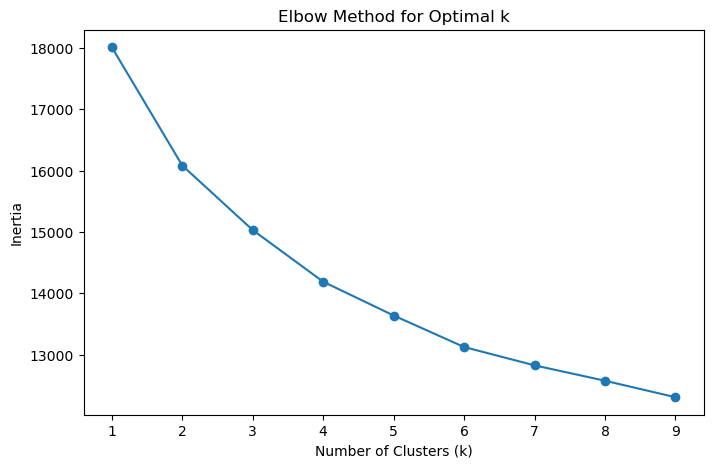

In [72]:
inertia = []
k_values = range(1, 10)

for k in k_values:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_cluster_processed)
    inertia.append(km.inertia_)

plt.figure(figsize=(8,5))
plt.plot(k_values, inertia, marker='o')
plt.title("Elbow Method for Optimal k")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.show()


#### The elbow plot shows how the K-Means inertia (sum of squared distances to cluster centers) decreases as k increases. We look for the point where additional clusters provide only marginal improvement—this indicates diminishing returns. In our case, inertia decreases sharply between k = 1 and k = 4, but the slope flattens noticeably after k = 4. This “bend” or “elbow” suggests that k = 4 provides a good balance between compact clusters and model simplicity, making it the most appropriate choice for our final K-Means model.

In [73]:
k = 4
kmeans = KMeans(n_clusters=k, random_state=42)
cluster_labels = kmeans.fit_predict(X_cluster_processed)

students["Cluster"] = cluster_labels
students["Cluster"].value_counts()

Cluster
0    618
1    605
3    596
2    573
Name: count, dtype: int64

# 6. Model Performance Comparison (Metrics and Visualizations)

#### In this section, we consolidate the performance results of all regression and classification models trained in Chapter 5. We present side-by-side comparison tables and visualizations summarizing key metrics—MAE, RMSE, and R² for regression, and accuracy, precision, recall, and F1 score for classification. This section focuses solely on reporting model metrics and visual summaries to enable an objective comparison. Full interpretation and discussion of these results are provided in Chapter 7.

## 6.1 Regression results

In [74]:
regression_results = pd.DataFrame({
    "Model": ["Linear Regression", "Random Forest Regressor", "XGBoost Regressor"],
    "MAE": [
        mean_absolute_error(y_test_reg, y_pred_linreg),
        mean_absolute_error(y_test_reg, y_pred_rf_reg),
        mean_absolute_error(y_test_reg, y_pred_xgb_reg)
    ],
    "RMSE": [
        math.sqrt(mean_squared_error(y_test_reg, y_pred_linreg)),
        math.sqrt(mean_squared_error(y_test_reg, y_pred_rf_reg)),
        math.sqrt(mean_squared_error(y_test_reg, y_pred_xgb_reg))
    ],
    "R2": [
        r2_score(y_test_reg, y_pred_linreg),
        r2_score(y_test_reg, y_pred_rf_reg),
        r2_score(y_test_reg, y_pred_xgb_reg)
    ]
})

regression_results

,Model,MAE,RMSE,R2
0,Linear Regression,0.155056,0.196308,0.953398
1,Random Forest Regressor,0.196029,0.252728,0.922761
2,XGBoost Regressor,0.183591,0.232796,0.934464


## 6.2 Classification results

In [75]:
# Classification Comparison Table
classification_results = pd.DataFrame({
    "Model": ["Logistic Regression", "Random Forest Classifier", "XGBoost Classifier"],
    "Accuracy": [
        accuracy_score(y_test_clf, y_pred_log),
        accuracy_score(y_test_clf, y_pred_rf),
        accuracy_score(y_test_clf, y_pred_xgb)
    ],
    "Precision": [
        precision_score(y_test_clf, y_pred_log),
        precision_score(y_test_clf, y_pred_rf),
        precision_score(y_test_clf, y_pred_xgb)
    ],
    "Recall": [
        recall_score(y_test_clf, y_pred_log),
        recall_score(y_test_clf, y_pred_rf),
        recall_score(y_test_clf, y_pred_xgb)
    ],
    "F1 Score": [
        f1_score(y_test_clf, y_pred_log),
        f1_score(y_test_clf, y_pred_rf),
        f1_score(y_test_clf, y_pred_xgb)
    ]
})

classification_results

,Model,Accuracy,Precision,Recall,F1 Score
0,Logistic Regression,0.947808,0.958457,0.967066,0.962742
1,Random Forest Classifier,0.926931,0.943620,0.952096,0.947839
2,XGBoost Classifier,0.939457,0.952522,0.961078,0.956781


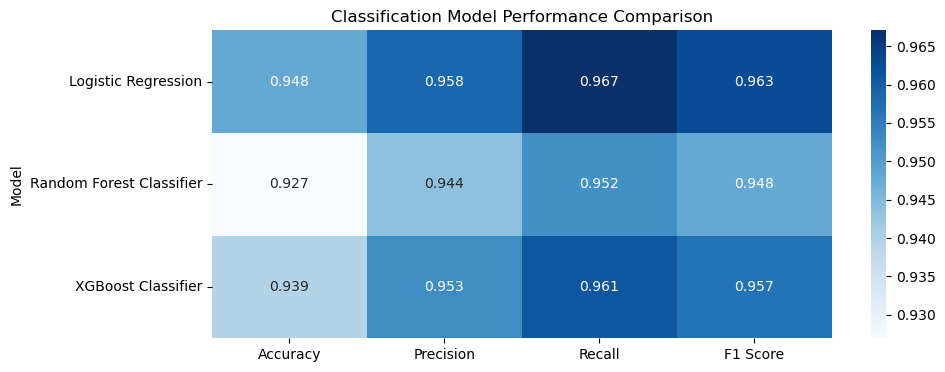

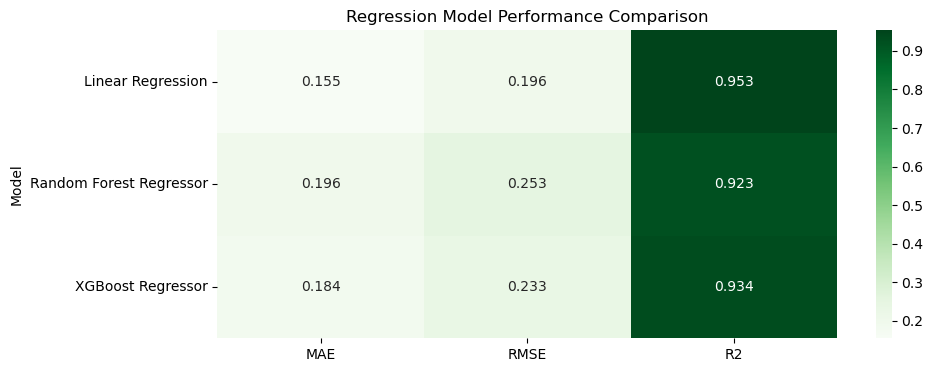

In [76]:
# Heatmap Visualization
plt.figure(figsize=(10,4))
sns.heatmap(classification_results.set_index("Model"), annot=True, fmt=".3f", cmap="Blues")
plt.title("Classification Model Performance Comparison")
plt.show()

plt.figure(figsize=(10,4))
sns.heatmap(regression_results.set_index("Model"), annot=True, fmt=".3f", cmap="Greens")
plt.title("Regression Model Performance Comparison")
plt.show()

## 6.3 SHAP Explanations (Regression & Classification)

#### In this section, we interpret SHAP (SHapley Additive exPlanations) values to understand how individual features influence model predictions. SHAP quantifies how each feature contributes to increasing or decreasing the predicted GPA or at-risk probability, providing direction-aware and model-consistent explanations. By examining these values, we gain deeper insight into why the regression and classification models behave as they do and how their learned patterns relate to the broader trends observed in our feature importance analyses.

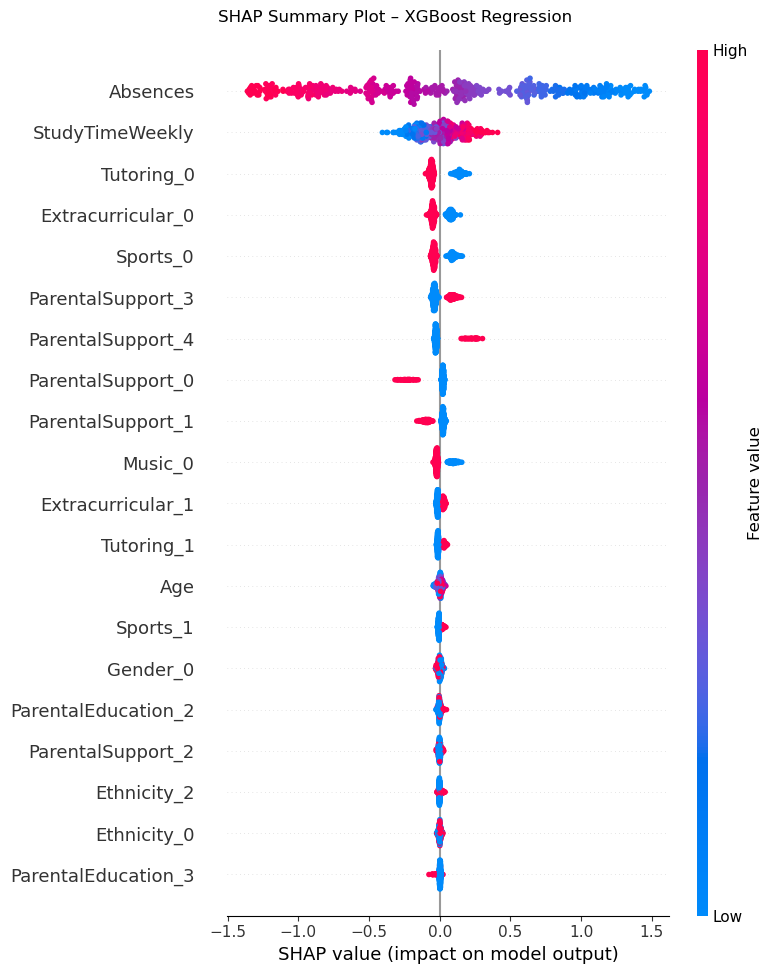

In [77]:
# Extract feature names after one-hot encoding
ohe = rf_reg_model.named_steps["preprocess"].named_transformers_["cat"]
encoded_cat_cols = ohe.get_feature_names_out(categorical_cols)
all_feature_names = np.concatenate([numeric_features, encoded_cat_cols])

# ---- Regression SHAP ----
xgb_reg = xgb_reg_model.named_steps["model"]
X_test_reg_transformed = xgb_reg_model.named_steps["preprocess"].transform(X_test_reg)

explainer_reg = shap.TreeExplainer(xgb_reg)
shap_values_reg = explainer_reg.shap_values(X_test_reg_transformed)

plt.figure()
shap.summary_plot(
    shap_values_reg,
    X_test_reg_transformed,
    feature_names=all_feature_names,
    show=False
)
plt.suptitle("SHAP Summary Plot – XGBoost Regression", y=1.02)
plt.show()


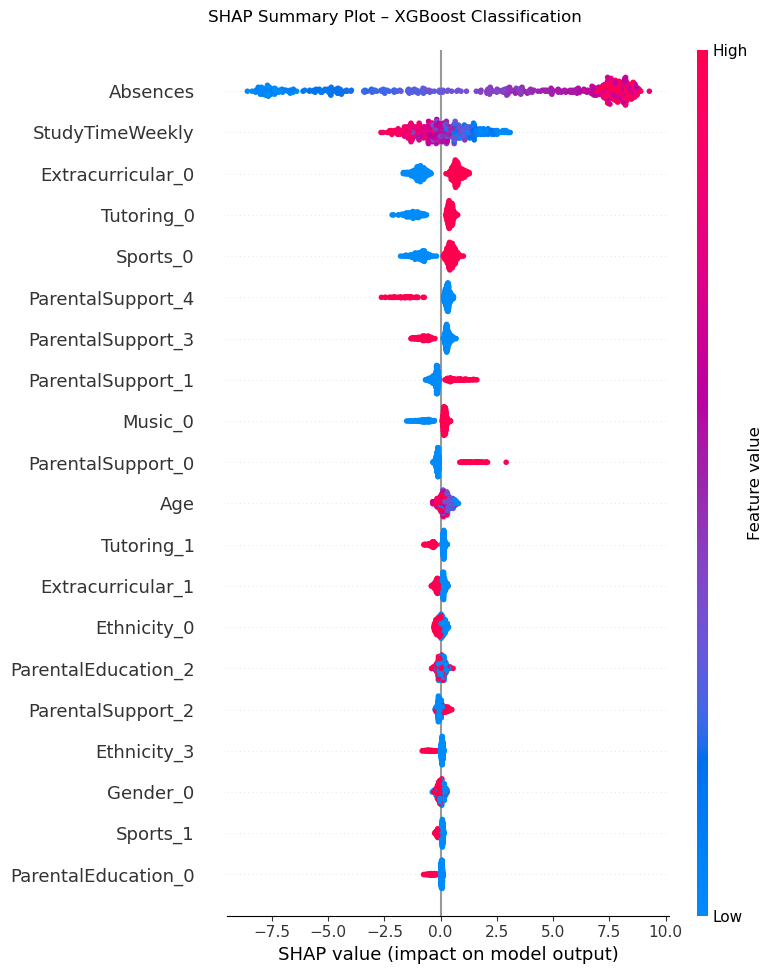

In [78]:
# ---- Classification SHAP ----
xgb_clf = xgb_clf_model.named_steps["model"]
X_test_clf_transformed = xgb_clf_model.named_steps["preprocess"].transform(X_test_clf)

explainer_clf = shap.TreeExplainer(xgb_clf)
shap_values_clf = explainer_clf.shap_values(X_test_clf_transformed)

sv_clf = shap_values_clf[1] if isinstance(shap_values_clf, list) else shap_values_clf

plt.figure()
shap.summary_plot(
    sv_clf,
    X_test_clf_transformed,
    feature_names=all_feature_names,
    show=False
)
plt.suptitle("SHAP Summary Plot – XGBoost Classification", y=1.02)
plt.show()

### Top 10 SHAP most important features for Regression 

In [79]:
reg_shap_importance = np.abs(shap_values_reg).mean(axis=0)

reg_shap_ranking = sorted(
    zip(all_feature_names, reg_shap_importance),
    key=lambda x: x[1],
    reverse=True
)

for feature, importance in reg_shap_ranking[:10]:
    print(f"{feature}: {importance:.4f}")


Absences: 0.7034
StudyTimeWeekly: 0.1299
Tutoring_0: 0.0838
Extracurricular_0: 0.0606
Sports_0: 0.0580
ParentalSupport_3: 0.0533
ParentalSupport_4: 0.0464
ParentalSupport_0: 0.0445
ParentalSupport_1: 0.0396
Music_0: 0.0369


### Top 10 SHAP most important features for Classification 

In [80]:
clf_shap_values = sv_clf 

clf_shap_importance = np.abs(clf_shap_values).mean(axis=0)

clf_shap_ranking = sorted(
    zip(all_feature_names, clf_shap_importance),
    key=lambda x: x[1],
    reverse=True
)

for feature, importance in clf_shap_ranking[:10]:
    print(f"{feature}: {importance:.4f}")

Absences: 5.8691
StudyTimeWeekly: 0.9780
Extracurricular_0: 0.8160
Tutoring_0: 0.6598
Sports_0: 0.6089
ParentalSupport_4: 0.4363
ParentalSupport_3: 0.4303
ParentalSupport_1: 0.3255
Music_0: 0.2955
ParentalSupport_0: 0.2807


## 6.4 Cluster results

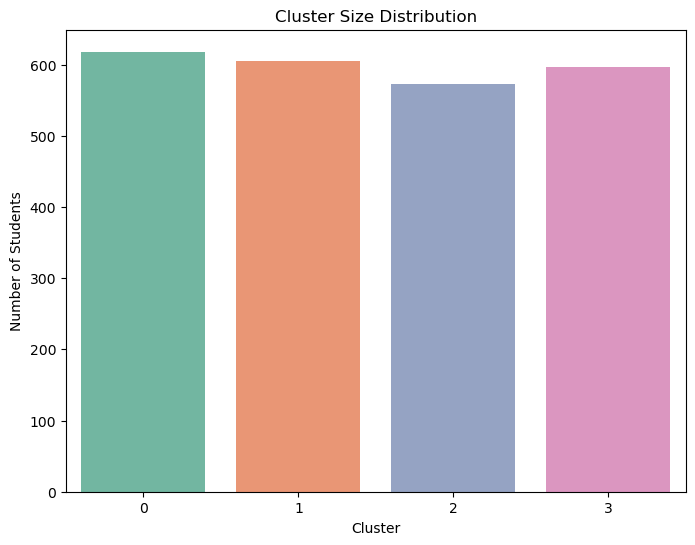

In [81]:
# Cluster Size Distribution

plt.figure(figsize=(8,6))
sns.countplot(
    x="Cluster", 
    data=students, 
    hue="Cluster",       # NEW
    palette="Set2",      # now valid
    legend=False         # hides duplicate legend
)
plt.title("Cluster Size Distribution")
plt.xlabel("Cluster")
plt.ylabel("Number of Students")
plt.show()

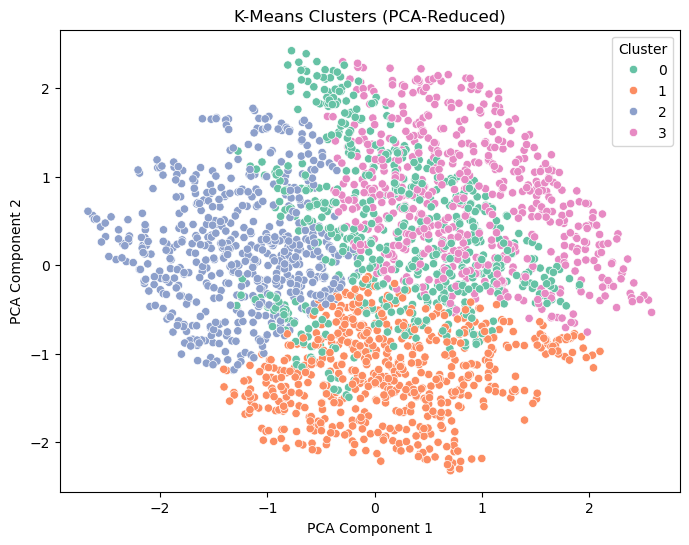

Note: PCA components are not real-world features. The axes represent mathematical directions that capture
the largest sources of variation after standardizing all features. The numeric range (approximately –2 to 2)
does not correspond to GPA or any original variable; it simply reflects how the high-dimensional data has been
projected into two dimensions for visualization.


In [82]:
# Visualize Clusters (PCA Projection)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_cluster_processed)

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=cluster_labels, palette="Set2")
plt.title("K-Means Clusters (PCA-Reduced)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.show()

# ---- Caption / Explanation ----
print(
    "Note: PCA components are not real-world features. The axes represent mathematical directions that capture\n"
    "the largest sources of variation after standardizing all features. The numeric range (approximately –2 to 2)\n"
    "does not correspond to GPA or any original variable; it simply reflects how the high-dimensional data has been\n"
    "projected into two dimensions for visualization."
)

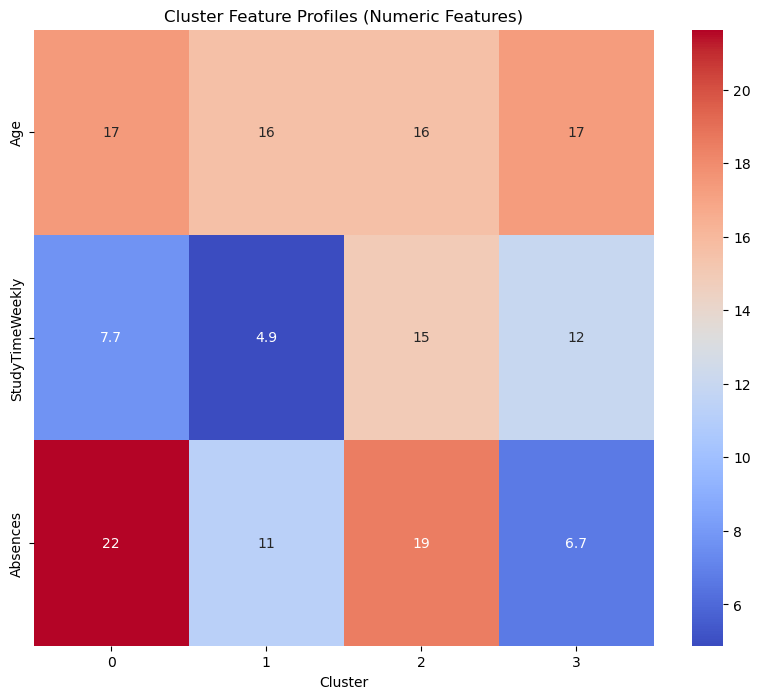

In [83]:
# Cluster profiles (feature averages)

cluster_profile = students.groupby("Cluster")[numeric_features].mean().T
cluster_profile

plt.figure(figsize=(10,8))
sns.heatmap(cluster_profile, annot=True, cmap="coolwarm")
plt.title("Cluster Feature Profiles (Numeric Features)")
plt.show()

# 7. Model Interpretation

#### In this chapter, we provide the narrative interpretation from the results of all supervised models and explain the patterns observed across regression, classification, and SHAP analyses. 

## 7.1 Regression Interpretation  
#### We begin by interpreting the regression models, analyzing how well they predict GPA and identifying which features most strongly influence continuous academic performance. We focus on key metrics such as MAE, RMSE, and R², and explain what these values reveal about overall model accuracy and error behavior.

                Feature  Importance
2              Absences    0.853273
1       StudyTimeWeekly    0.057347
19           Tutoring_0    0.008131
14    ParentalSupport_0    0.007964
18    ParentalSupport_4    0.007662
20           Tutoring_1    0.007653
15    ParentalSupport_1    0.005783
0                   Age    0.005711
17    ParentalSupport_3    0.005023
21    Extracurricular_0    0.004086
23             Sports_0    0.003965
22    Extracurricular_1    0.003899
24             Sports_1    0.003669
25              Music_0    0.002230
11  ParentalEducation_2    0.002129


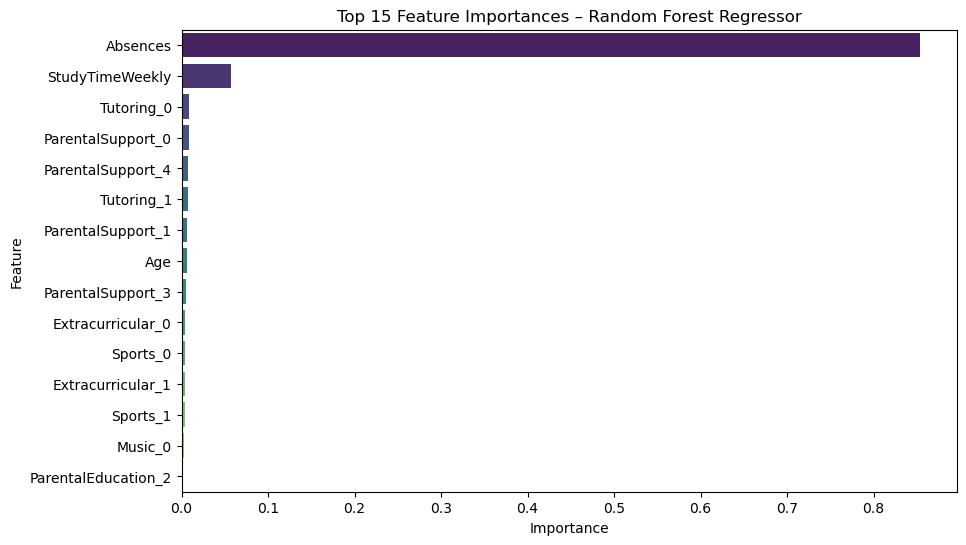

In [84]:
# Random Forest Regression 

rf_reg_importances = rf_reg_model.named_steps["model"].feature_importances_

# Create a dataframe
rf_reg_df = pd.DataFrame({
    "Feature": all_feature_names,
    "Importance": rf_reg_importances
}).sort_values("Importance", ascending=False)

print(rf_reg_df.head(15))


# Random Forest Regressor
plot_feature_importances(
    rf_reg_df,
    "Top 15 Feature Importances – Random Forest Regressor",
    palette="viridis"
)

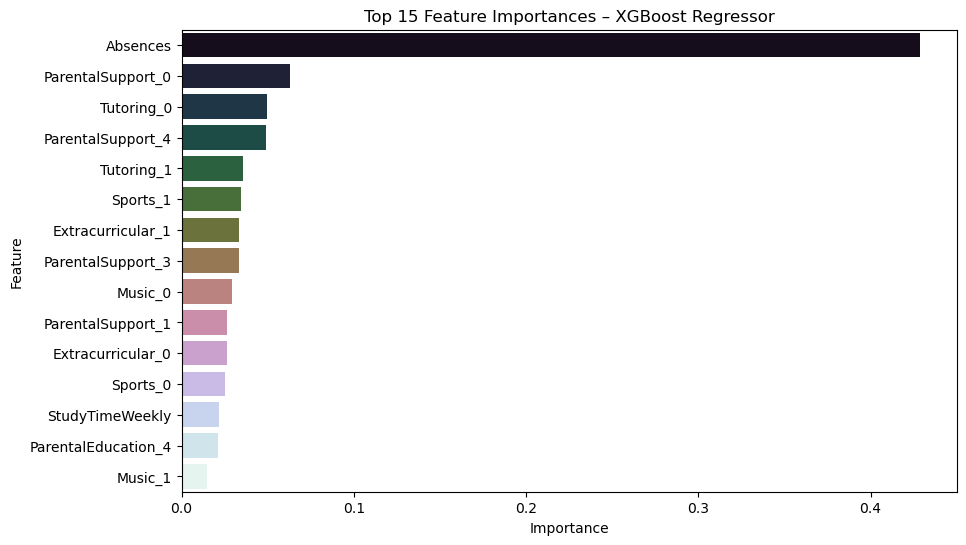

In [85]:
# XGBoost Regression
xgb_reg_importances = xgb_reg_model.named_steps["model"].feature_importances_

xgb_reg_df = pd.DataFrame({
    "Feature": all_feature_names,
    "Importance": xgb_reg_importances
}).sort_values("Importance", ascending=False)

xgb_reg_df.head(15)

# XGBoost Regressor
plot_feature_importances(
    xgb_reg_df,
    "Top 15 Feature Importances – XGBoost Regressor",
    palette="cubehelix"
)

## 7.2 Classification Interpretation  
#### Next, we interpret the classification models by examining how effectively they identify at-risk students. Using accuracy, precision, recall, and F1 score, we explain the strengths and limitations of each classifier. We also highlight which features play the largest role in distinguishing at-risk from not-at-risk students.

                Feature  Importance
2              Absences    0.610842
1       StudyTimeWeekly    0.102231
0                   Age    0.033504
15    ParentalSupport_1    0.013007
5           Ethnicity_0    0.012721
10  ParentalEducation_1    0.011670
3              Gender_0    0.011585
11  ParentalEducation_2    0.011512
17    ParentalSupport_3    0.011360
4              Gender_1    0.011074
20           Tutoring_1    0.010951
18    ParentalSupport_4    0.010684
21    Extracurricular_0    0.010578
16    ParentalSupport_2    0.010518
22    Extracurricular_1    0.010459


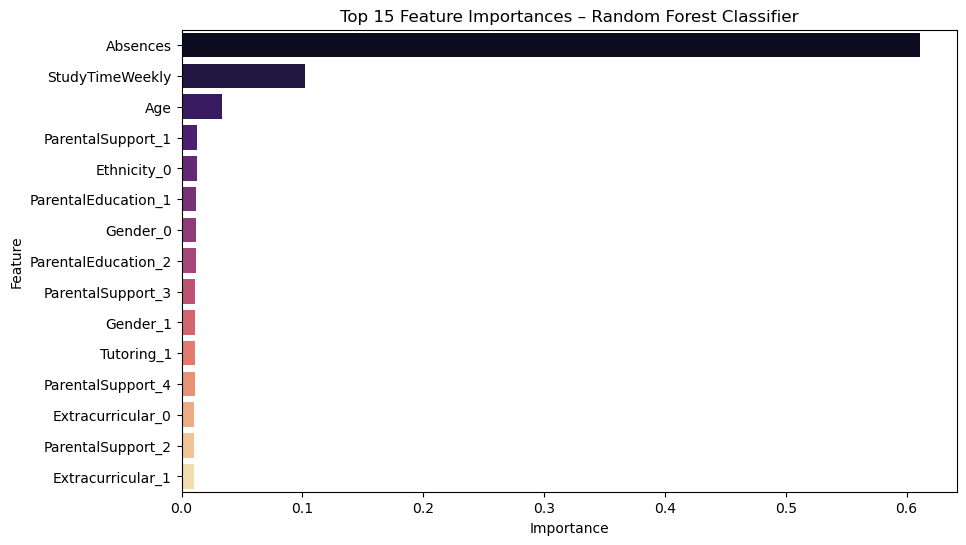

In [86]:
# Random Forest Classifier (At-Risk)

rf_clf_importances = rf_clf_model.named_steps["model"].feature_importances_

rf_clf_df = pd.DataFrame({
    "Feature": all_feature_names,
    "Importance": rf_clf_importances
}).sort_values("Importance", ascending=False)

print(rf_clf_df.head(15))

# Random Forest Classifier
plot_feature_importances(
    rf_clf_df,
    "Top 15 Feature Importances – Random Forest Classifier",
    palette="magma"
)


                Feature  Importance
2              Absences    0.256182
13  ParentalEducation_4    0.047255
18    ParentalSupport_4    0.042137
19           Tutoring_0    0.041538
20           Tutoring_1    0.041023
22    Extracurricular_1    0.040475
14    ParentalSupport_0    0.037292
25              Music_0    0.035401
15    ParentalSupport_1    0.033411
21    Extracurricular_0    0.032602
17    ParentalSupport_3    0.031001
8           Ethnicity_3    0.026167
26              Music_1    0.025825
4              Gender_1    0.025725
27       Volunteering_0    0.025645


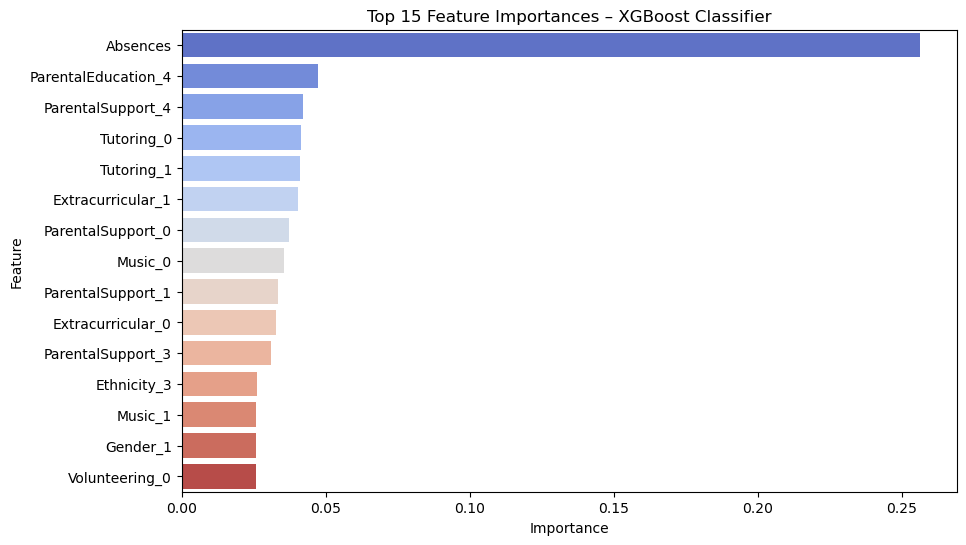

In [87]:
# XGBoost Classification
xgb_clf_importances = xgb_clf_model.named_steps["model"].feature_importances_

xgb_clf_df = pd.DataFrame({
    "Feature": all_feature_names,
    "Importance": xgb_clf_importances
}).sort_values("Importance", ascending=False)

print(xgb_clf_df.head(15))

# XGBoost Classifier
plot_feature_importances(
    xgb_clf_df,
    "Top 15 Feature Importances – XGBoost Classifier",
    palette="coolwarm"
)

### Comparing Patterns Across Regression and Classification  

#### While regression and classification performance metrics cannot be compared directly, we can meaningfully compare **feature patterns** across both tasks. In this section, we describe which features consistently emerge as important across models, where the tasks diverge, and what these patterns suggest about the underlying drivers of academic outcomes.

## 7.3 Clustering Interpretation

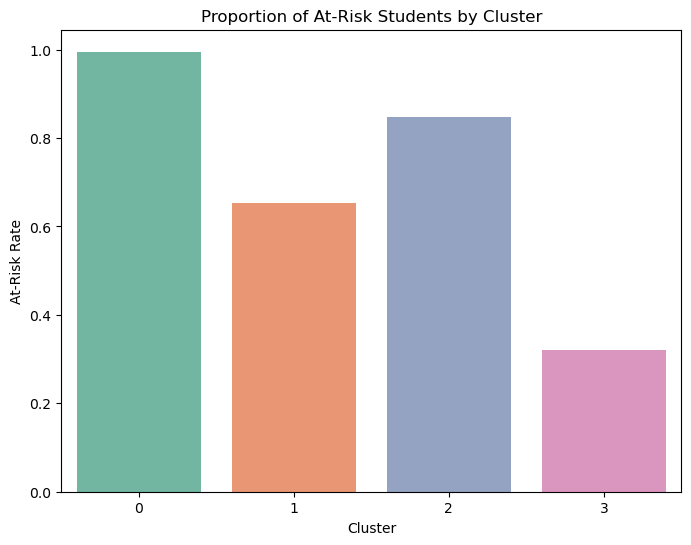

In [88]:
# At-Risk Rate by Cluster

cluster_risk = students.groupby("Cluster")["at_risk"].mean().reset_index()
cluster_risk.columns = ["Cluster", "AtRiskRate"]

plt.figure(figsize=(8,6))
sns.barplot(
    data=cluster_risk,
    x="Cluster",
    y="AtRiskRate",
    hue="Cluster",         # required for palette usage
    palette="Set2",
    dodge=False,           # keeps bars single, not split
    legend=False           # hides redundant legend
)
plt.title("Proportion of At-Risk Students by Cluster")
plt.xlabel("Cluster")
plt.ylabel("At-Risk Rate")
plt.show()

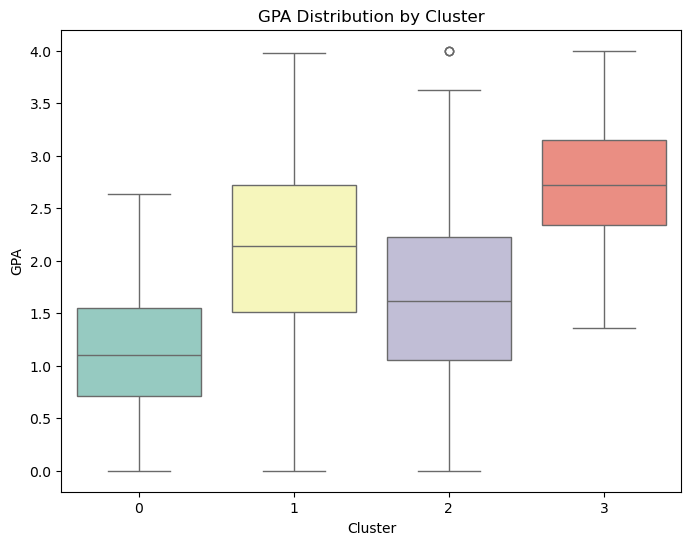

In [89]:
# GPA distribution by cluster

plt.figure(figsize=(8,6))
sns.boxplot(
    data=students,
    x="Cluster",
    y="GPA",
    hue="Cluster",        # required when using palette
    palette="Set3",
    dodge=False,          # avoid side-by-side boxes
    legend=False          # hide duplicate legend
)
plt.title("GPA Distribution by Cluster")
plt.show()

## 7.4 SHAP Interpretation

#### SHAP values help explain which features most influence our XGBoost regression and classification predictions. The patterns are highly consistent across both models.

**Regression (Predicting GPA):**
- **Absences** is the strongest negative driver of GPA by a wide margin.
- **StudyTimeWeekly** increases predicted GPA.
- Lack of participation in activities (e.g., Tutoring_0, Extracurricular_0, Sports_0, Music_0) generally lowers GPA.
- Higher **ParentalSupport** levels push GPA upward.

**Classification (Predicting At-Risk Status):**
- **Absences** again dominates, sharply increasing the at-risk probability.
- **StudyTimeWeekly** decreases at-risk likelihood.
- Not participating in tutoring or activities increases risk.
- Higher **ParentalSupport** reduces risk.

Overall, SHAP confirms the same key pattern seen across all models: **absenteeism and study habits are the primary behavioral drivers of academic outcomes, with parental support and extracurricular engagement playing meaningful secondary roles.**

## 7.5 Narrative Interpretation
### Interpretation of Model Results

Across both regression and classification tasks, several patterns emerge in the feature
importance and SHAP analyses:

1. **Study Time** consistently appears as one of the strongest predictors of GPA. Students
   who report studying more hours per week tend to achieve higher GPA values.

2. **Absences** are also among the top predictors. Higher absenteeism is strongly associated
   with lower academic performance, and it is one of the clearest indicators of “at-risk” status.

3. **Parental Education** and **Parental Support** appear as moderately influential factors,
   suggesting that home environment and family engagement may play important roles in
   shaping student outcomes.

4. **Participation in Extracurricular Activities**, such as sports or music, provides modest
   predictive power. In some models, sports participation slightly increases predicted GPA,
   potentially reflecting higher engagement or time management skills.

5. SHAP values reveal nuanced individual-level explanations. For example, a student with
   high study time and strong parental support may still be at risk if they also have high
   absenteeism or low past performance.

Taken together, these results highlight that academic behaviors—especially study habits
and attendance—are more predictive of performance than demographic factors. This aligns
with findings in education research and suggests actionable intervention points for
schools seeking to improve student outcomes.


### Interpretation of Clustering Results

The K-Means clustering analysis using four clusters reveals several meaningful patterns in the student population. Each cluster represents a distinct subgroup of students who share similar academic behaviors, background traits, and engagement patterns.

The clusters show clear differences in GPA distributions. At least one cluster contains students with lower median GPAs and a higher proportion of at-risk students, suggesting that certain combinations of study habits, attendance, and family support correspond strongly with weaker academic outcomes. Conversely, another cluster shows higher GPAs associated with more consistent study patterns or stronger support structures.

At-risk rates vary substantially across the four clusters, indicating that different subgroups face different academic challenges. Some clusters appear to reflect students with strong study routines and stable attendance, while others capture students with more absences, less support, or inconsistent study habits—factors that correlate with increased risk levels.

These cluster profiles illuminate the underlying structure of the dataset and help translate the raw features into meaningful categories. For example, clusters characterized by higher study time or fewer absences tend to align with better academic outcomes, whereas clusters with lower study engagement or weaker support tend to align with poorer performance.

Overall, the clustering analysis complements the supervised learning models by offering a group-level perspective. Rather than focusing only on individual predictions, clustering helps identify specific student subgroups that may benefit from targeted academic interventions, personalized outreach, or support strategies. This unsupervised approach demonstrates how AI can enrich educational decision-making by revealing patterns that might otherwise remain hidden.

### ChatGPT Disclosure
ChatGPT was used as a tool at different stages of this project. Most often, ChatGPT was used to reference syntax and debug code segments when there were errors present. ChatGPT also recommended several techniques to better format code, which were often utilized.